In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

Install `leidenalg` dependency if needed:

In [2]:
#!pip3 install leidenalg

### Download data
This tutorial uses two 10X datasets that are processed in parallel:

- the [3k PBMC (v1 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k) dataset
- the [10k PBMC (v3 chemistry)](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3?) dataset

Uncomment this cell to create directories, download and unpack:

In [3]:
# !mkdir tutorial_data
# !mkdir tutorial_data/pbmc3k_v1
# !mkdir tutorial_data/pbmc10k_v3

# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O tutorial_data/pbmc3k_v1.tar.gz
# !cd tutorial_data; tar -xzf pbmc3k_v1.tar.gz -C pbmc3k_v1 --strip-components 2

# !wget https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz -O tutorial_data/pbmc10k_v3.tar.gz
# !cd tutorial_data; tar -xzf pbmc10k_v3.tar.gz -C pbmc10k_v3 --strip-components 1

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.0.dev17+g4e4e6abe anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.0 pandas==1.3.1 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


### Load data

In [5]:
adata_pbmc3k = sc.read_10x_mtx("tutorial_data/pbmc3k_v1/", cache=True)
adata_pbmc10k = sc.read_10x_mtx("tutorial_data/pbmc10k_v3/", cache=True)

adata_pbmc3k.uns["name"] = "PBMC 3k (v1)"
adata_pbmc10k.uns["name"] = "PBMC 10k (v3)"

... reading from cache file cache/tutorial_data-pbmc3k_v1-matrix.h5ad
... reading from cache file cache/tutorial_data-pbmc10k_v3-matrix.h5ad


### Perform Quality control
First, we remove cells and genes with no counts, then remove outlier cells. Parameters and thresholds inspired from [the PBMC3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [6]:
# filtering
for adata in [adata_pbmc3k, adata_pbmc10k]:
    adata.var_names_make_unique()
    print(adata.uns["name"], ": data shape:", adata.shape)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

PBMC 3k (v1) : data shape: (2700, 32738)
filtered out 19024 genes that are detected in less than 3 cells
PBMC 10k (v3) : data shape: (11769, 33538)
filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


PBMC 3k (v1) :


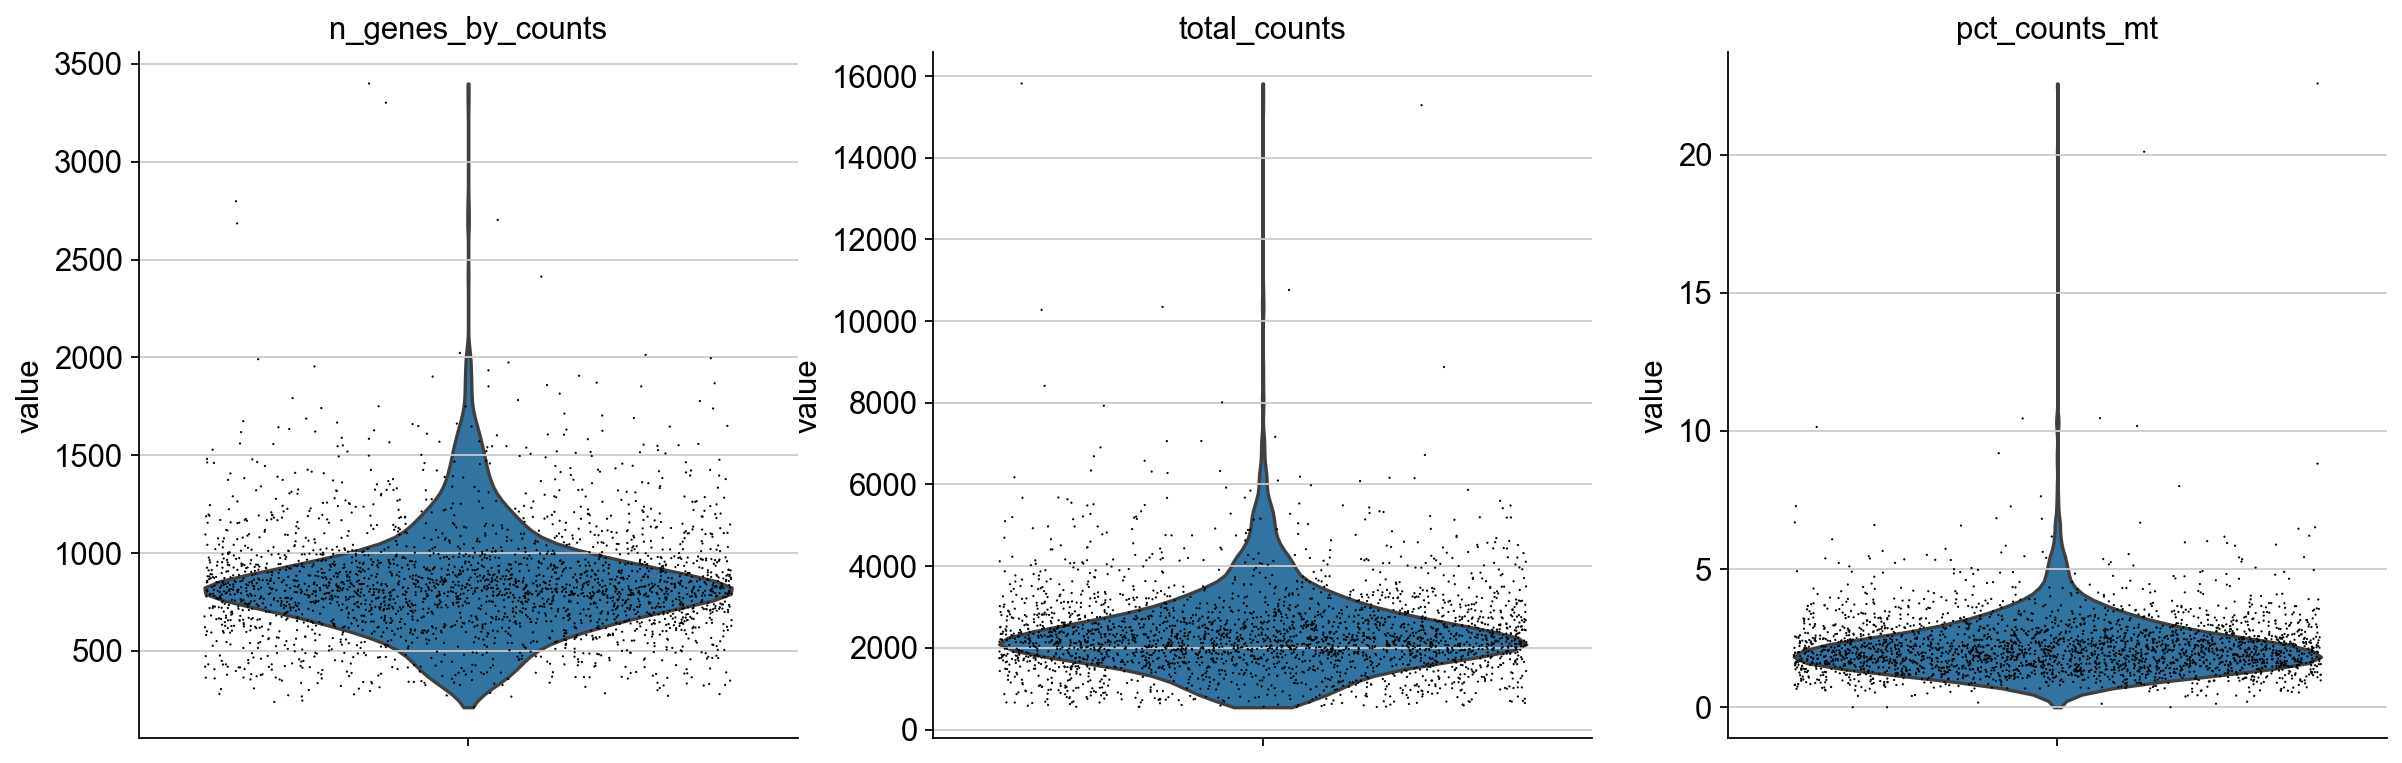

PBMC 10k (v3) :


/Users/giovanni.palla/miniconda3/envs/scanpy_dev/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


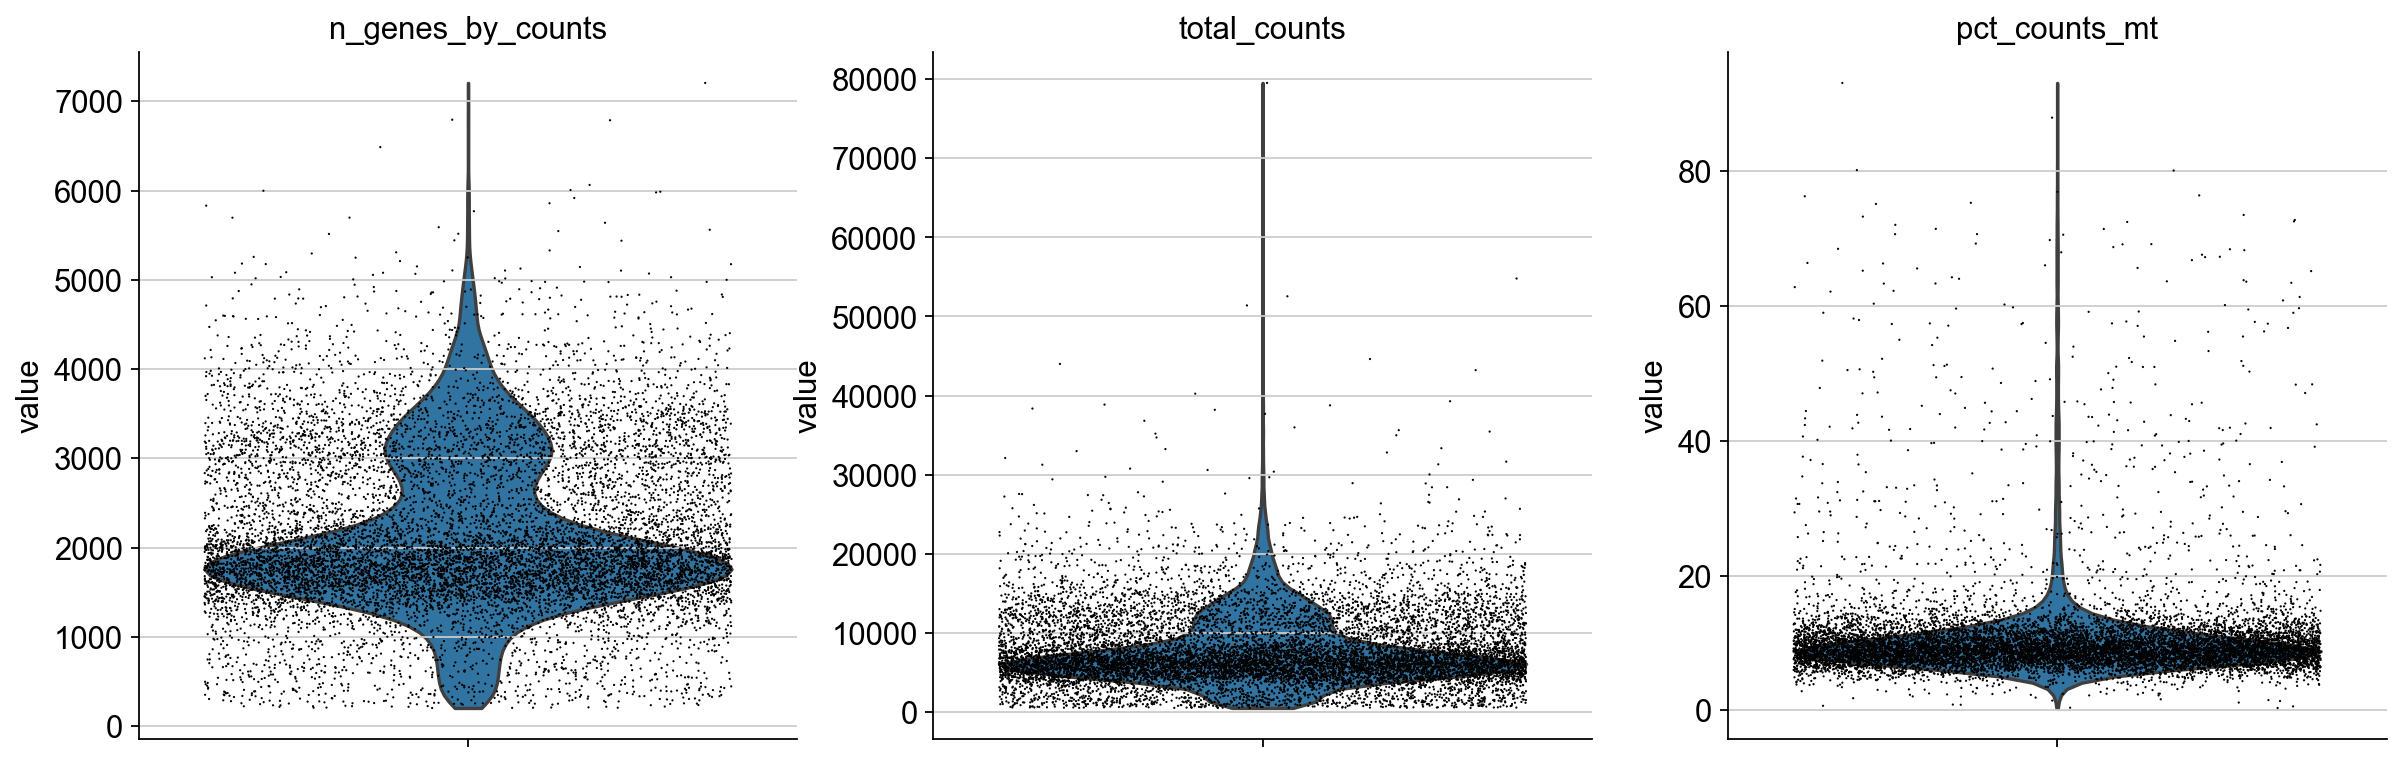

In [7]:
# show quality control criteria
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True,
    )

In [8]:
# set thresholds and do the filtering
adata_pbmc3k.uns["threshold_mt"] = 5
adata_pbmc3k.uns["threshold_total"] = 5000
adata_pbmc3k.uns["threshold_ngenes"] = 2500
adata_pbmc10k.uns["threshold_mt"] = 20
adata_pbmc10k.uns["threshold_total"] = 25000
adata_pbmc10k.uns["threshold_ngenes"] = 6000

afterfilter = []
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    print(
        "removing %u cells with high %% of mitochondrial genes"
        % (sum(adata.obs.pct_counts_mt >= adata.uns["threshold_mt"]))
    )
    adata = adata[adata.obs.pct_counts_mt < adata.uns["threshold_mt"], :]

    print(
        "removing additional %u cells with large total counts"
        % (sum(adata.obs.total_counts >= adata.uns["threshold_total"]))
    )
    adata = adata[adata.obs.total_counts < adata.uns["threshold_total"], :]

    print(
        "removing additional %u cells with large number of genes"
        % (sum(adata.obs.n_genes_by_counts >= adata.uns["threshold_ngenes"]))
    )
    adata = adata[adata.obs.n_genes_by_counts < adata.uns["threshold_ngenes"], :]

    print("make sure that after filtering cells, all genes have at least 1 cell left..")
    sc.pp.filter_genes(adata, min_cells=1)
    afterfilter.append(adata)
adata_pbmc3k, adata_pbmc10k = afterfilter

PBMC 3k (v1) :
removing 57 cells with high % of mitochondrial genes
removing additional 69 cells with large total counts
removing additional 0 cells with large number of genes
make sure that after filtering cells, all genes have at least 1 cell left..
filtered out 2 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


PBMC 10k (v3) :
removing 494 cells with high % of mitochondrial genes
removing additional 75 cells with large total counts
removing additional 0 cells with large number of genes
make sure that after filtering cells, all genes have at least 1 cell left..
filtered out 1 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


### Use Pearson residuals for selection of highly variable genes

Analytic Pearson residuals can be used to identify biologically variable genes. For that, the observed counts are compared to expected counts of a "null model". This model includes no biological variability between cells. Pearson residuals are defined such that genes that are not differentially expressed will have variance close to 1. In contrast, if a gene is differentially expressed, it will deviate from the null model, causing larger residuals and residual variance >1 for this gene. 

The call to `highly_variable_genes(flavor='pearson_residuals',n_top_genes=2000)` computes the residual variances and selects 2000 genes based on this. As shown in the plots below, cell type marker genes known *a priori* are successfully selected.



extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


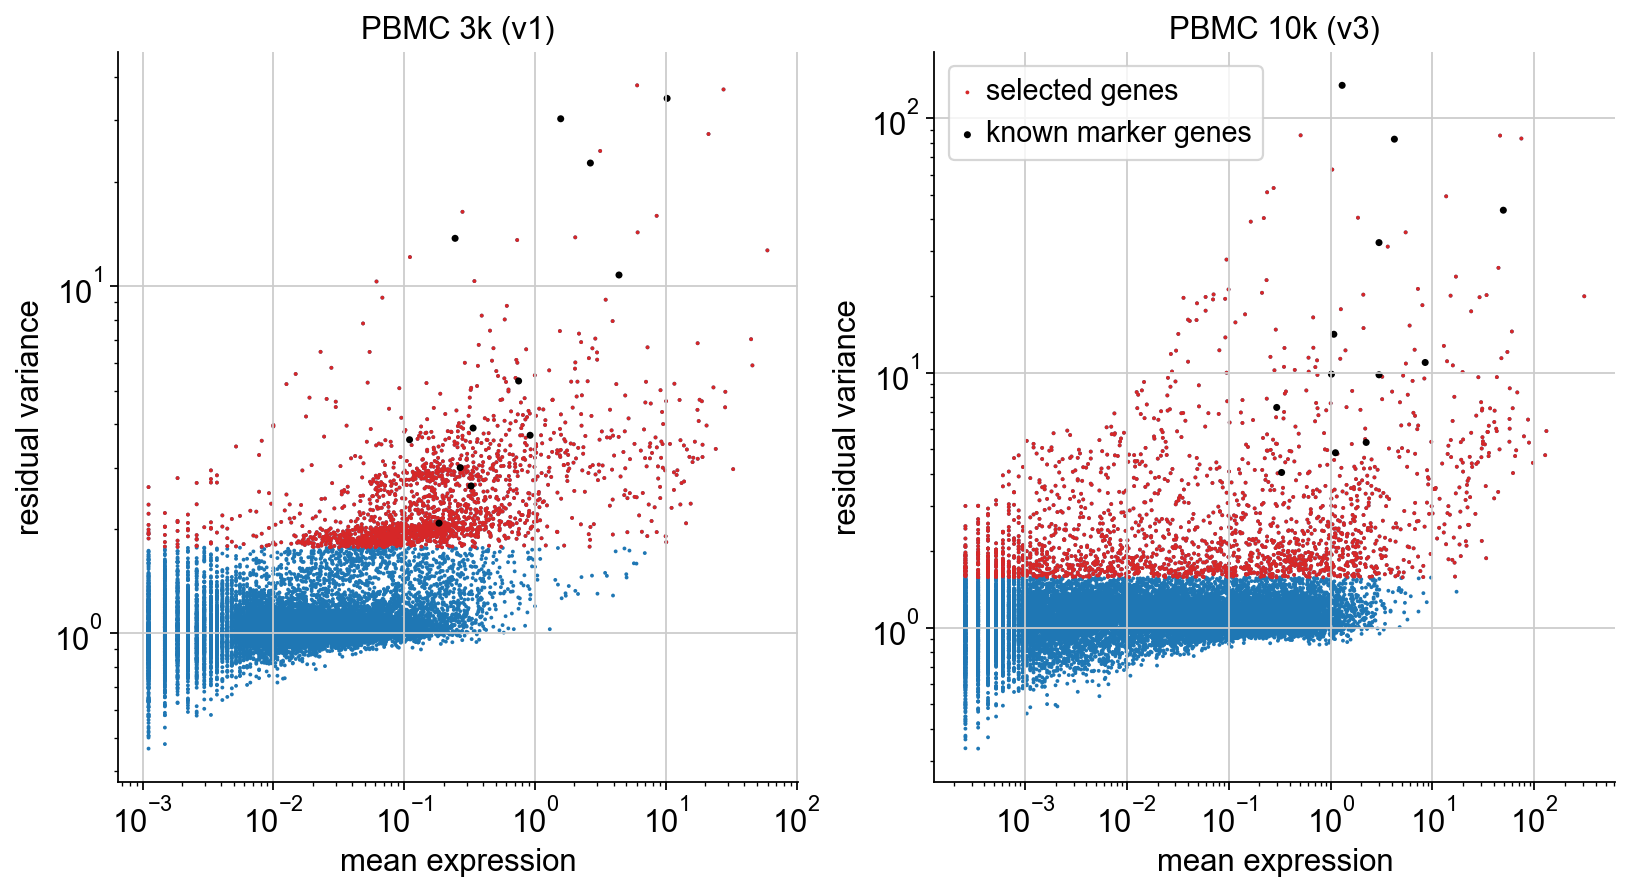

In [9]:
# marker genes from table in pbmc3k tutorial
markers_scanpy = [
    "IL7R",
    "LYZ",
    "CD14",
    "MS4A1",
    "CD8A",
    "GNLY",
    "NKG7",
    "FCGR3A",
    "MS4A7",
    "FCER1A",
    "CST3",
    "PPBP",
]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, adata in zip(axes, [adata_pbmc3k, adata_pbmc10k]):

    sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=2000
    )
    hvgs = adata.var["highly_variable"]

    ax.scatter(
        adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
    )
    ax.scatter(
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
    ax.scatter(
        adata.var["mean_counts"][np.isin(adata.var_names, markers_scanpy)],
        adata.var["residual_variances"][np.isin(adata.var_names, markers_scanpy)],
        c="k",
        label="known marker genes",
        s=10,
        edgecolor="none",
    )
    ax.set_xscale("log")
    ax.set_xlabel("mean expression")
    ax.set_yscale("log")
    ax.set_ylabel("residual variance")
    ax.set_title(adata.uns["name"])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
plt.legend()

The marker genes used in this notebook were taken from the [the PBMC3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html); their names are:
```
['IL7R',            # CD4 T cells
 'LYZ', 'CD14',     # CD14+ Monocytes
 'MS4A1',           # B cells
 'CD8A',            # CD8 T cells
 'GNLY', 'NKG7',    # NK cells
 'FCGR3A', 'MS4A7', # FCGR3A+ Monocytes
 'FCER1A', 'CST3',  # Dendritic Cells
 'PPBP']            # Megakaryocytes

```

#### Actually filter genes

In [10]:
afterhvg = []
for adata in [adata_pbmc3k, adata_pbmc10k]:

    # do the filtering
    adata = adata[:, adata.var["highly_variable"]]
    afterhvg.append(adata)
adata_pbmc3k, adata_pbmc10k = afterhvg

# after filtering, keep raw and depth-normalized counts for later
adata_pbmc3k.layers["raw"] = adata_pbmc3k.X.copy()
adata_pbmc3k.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_pbmc3k, inplace=False)["X"]
)

adata_pbmc10k.layers["raw"] = adata_pbmc10k.X.copy()
adata_pbmc10k.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_pbmc10k, inplace=False)["X"]
)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [11]:
adata_pbmc3k

AnnData object with n_obs × n_vars = 2574 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'name', 'threshold_mt', 'threshold_total', 'threshold_ngenes', 'hvg'
    layers: 'raw', 'sqrt_norm'

In [12]:
adata_pbmc10k

AnnData object with n_obs × n_vars = 10968 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'name', 'threshold_mt', 'threshold_total', 'threshold_ngenes', 'hvg'
    layers: 'raw', 'sqrt_norm'

### Normalize raw counts by transforming them to Pearson residuals

When computing Pearson residuals, we implicitly perform normalization by sequencing depth and variance stabilization. Also, genes that are differentially expressed (especially in small subpopulations) will produce larger residuals than homogenously expressed genes. This is why it makes sense to use them as basis for downstream processing. 

We transform our raw counts to residuals by calling `normalize_pearson_residuals(adata)`.
In our example pipeline, we then apply PCA to reduce to the most relevant dimensions of the dataset. Then, we visualize this reduced representation with tSNE and perform Leiden clustering, which is again taken from [the PBMC3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [13]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.experimental.pp.normalize_pearson_residuals(adata)

computing analytic Pearson residuals on adata.X
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


### Compute PCA and tSNE

We use the tSNE settings suggested by [Kobak & Berens (2019)](https://doi.org/10.1038/s41467-019-13056-x)

In [14]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.pp.pca(adata, n_comps=50)
    n_cells = len(adata)
    sc.tl.tsne(
        adata, use_rep="X_pca", learning_rate=n_cells / 12, perplexity=n_cells / 100
    )

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:14)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:47)


### Compute Neighborhood graph and Leiden clustering

In [15]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
    sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


### Show Leiden clusters on tSNE and PBMC marker genes

PBMC 3k (v1) :


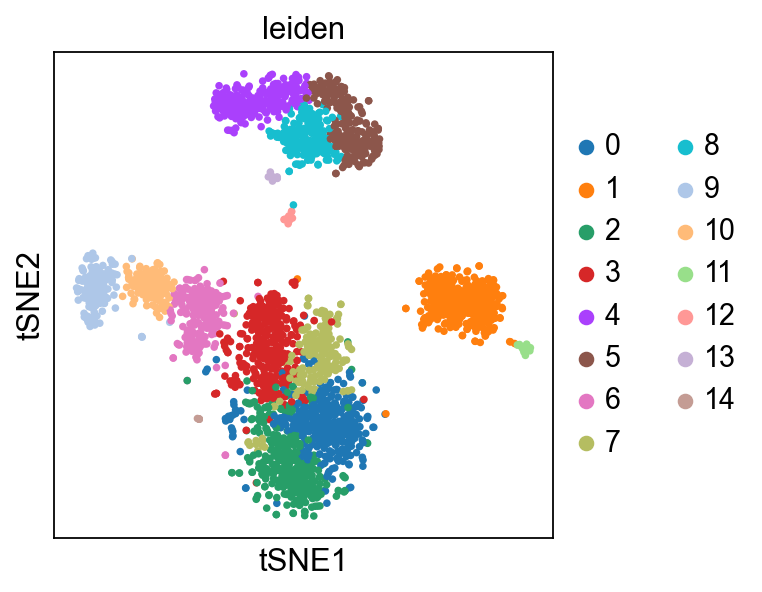

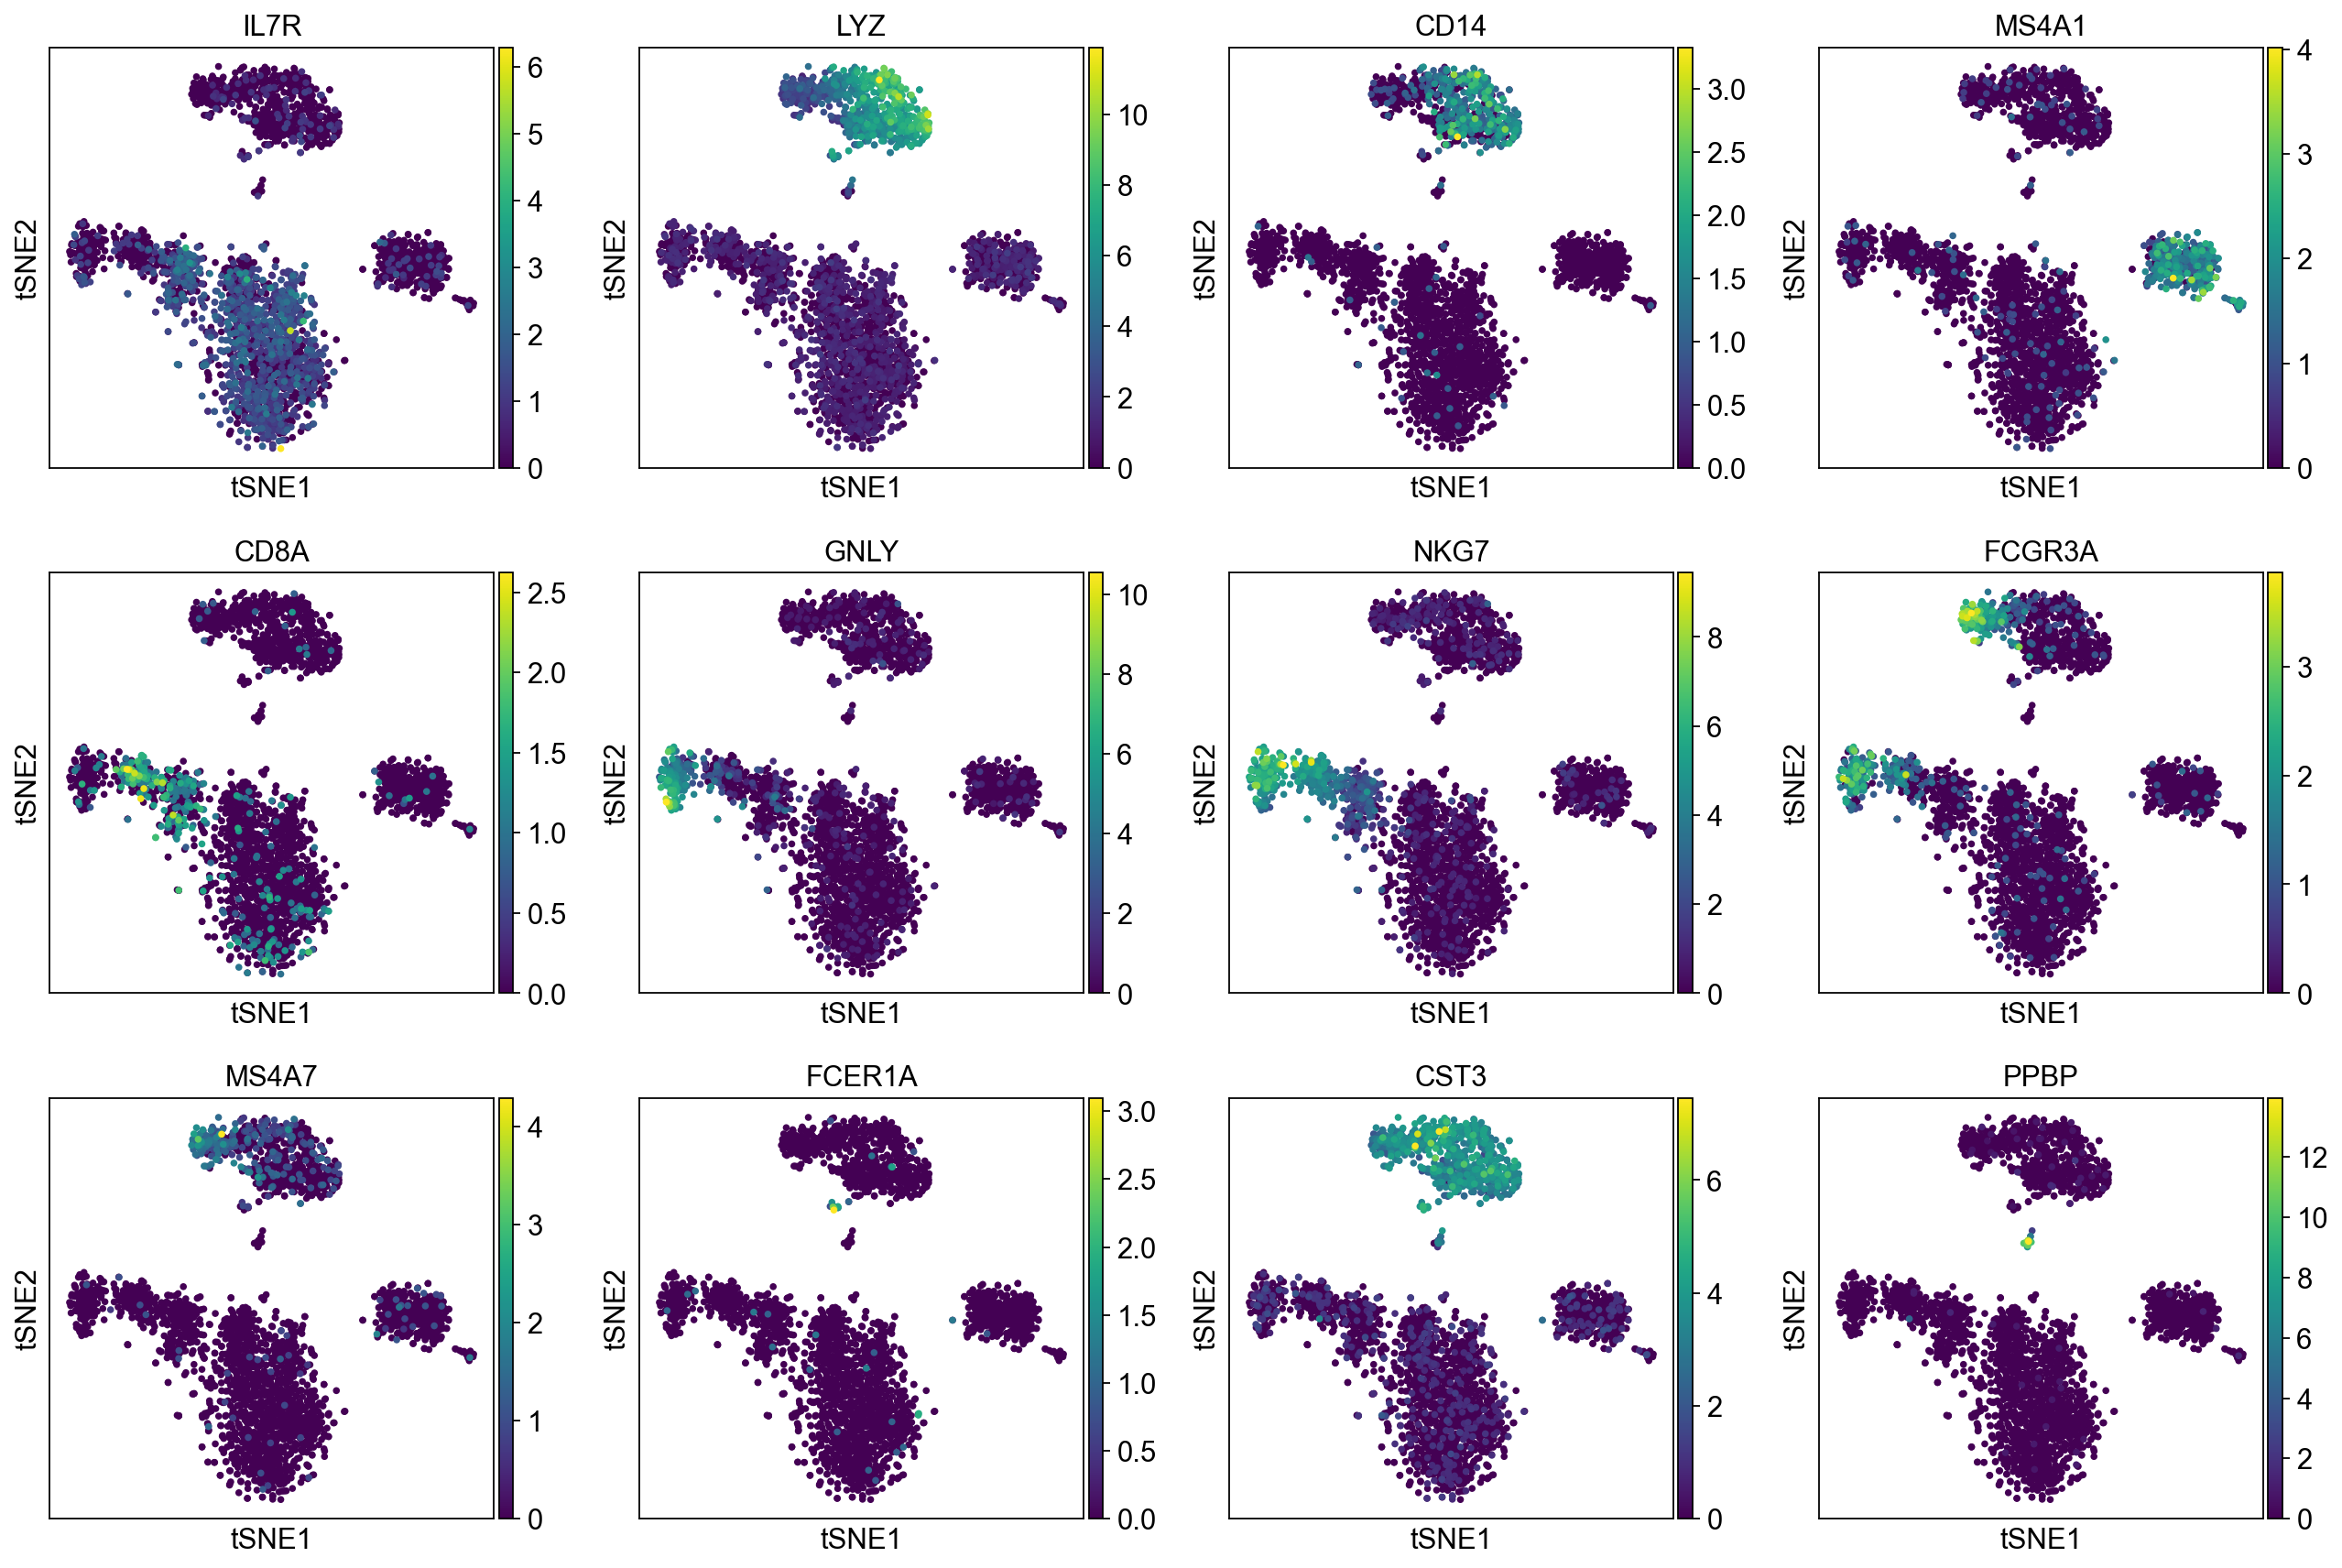

PBMC 10k (v3) :


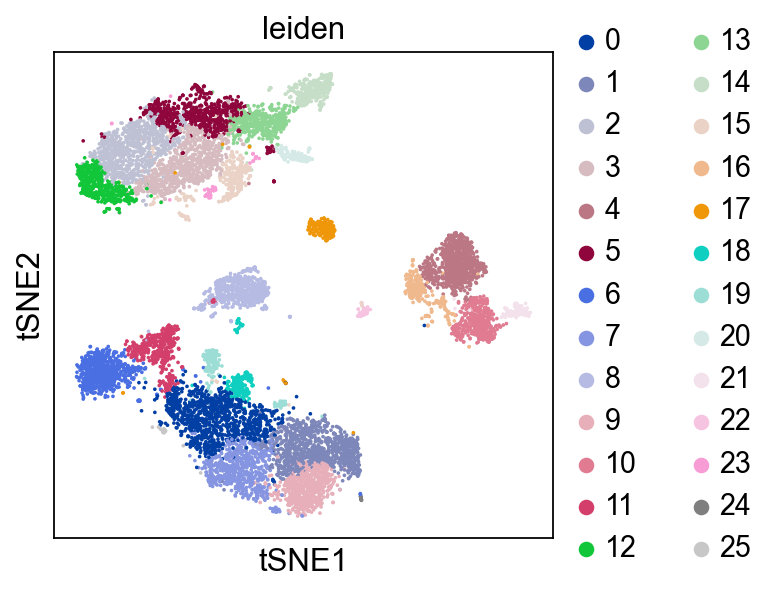

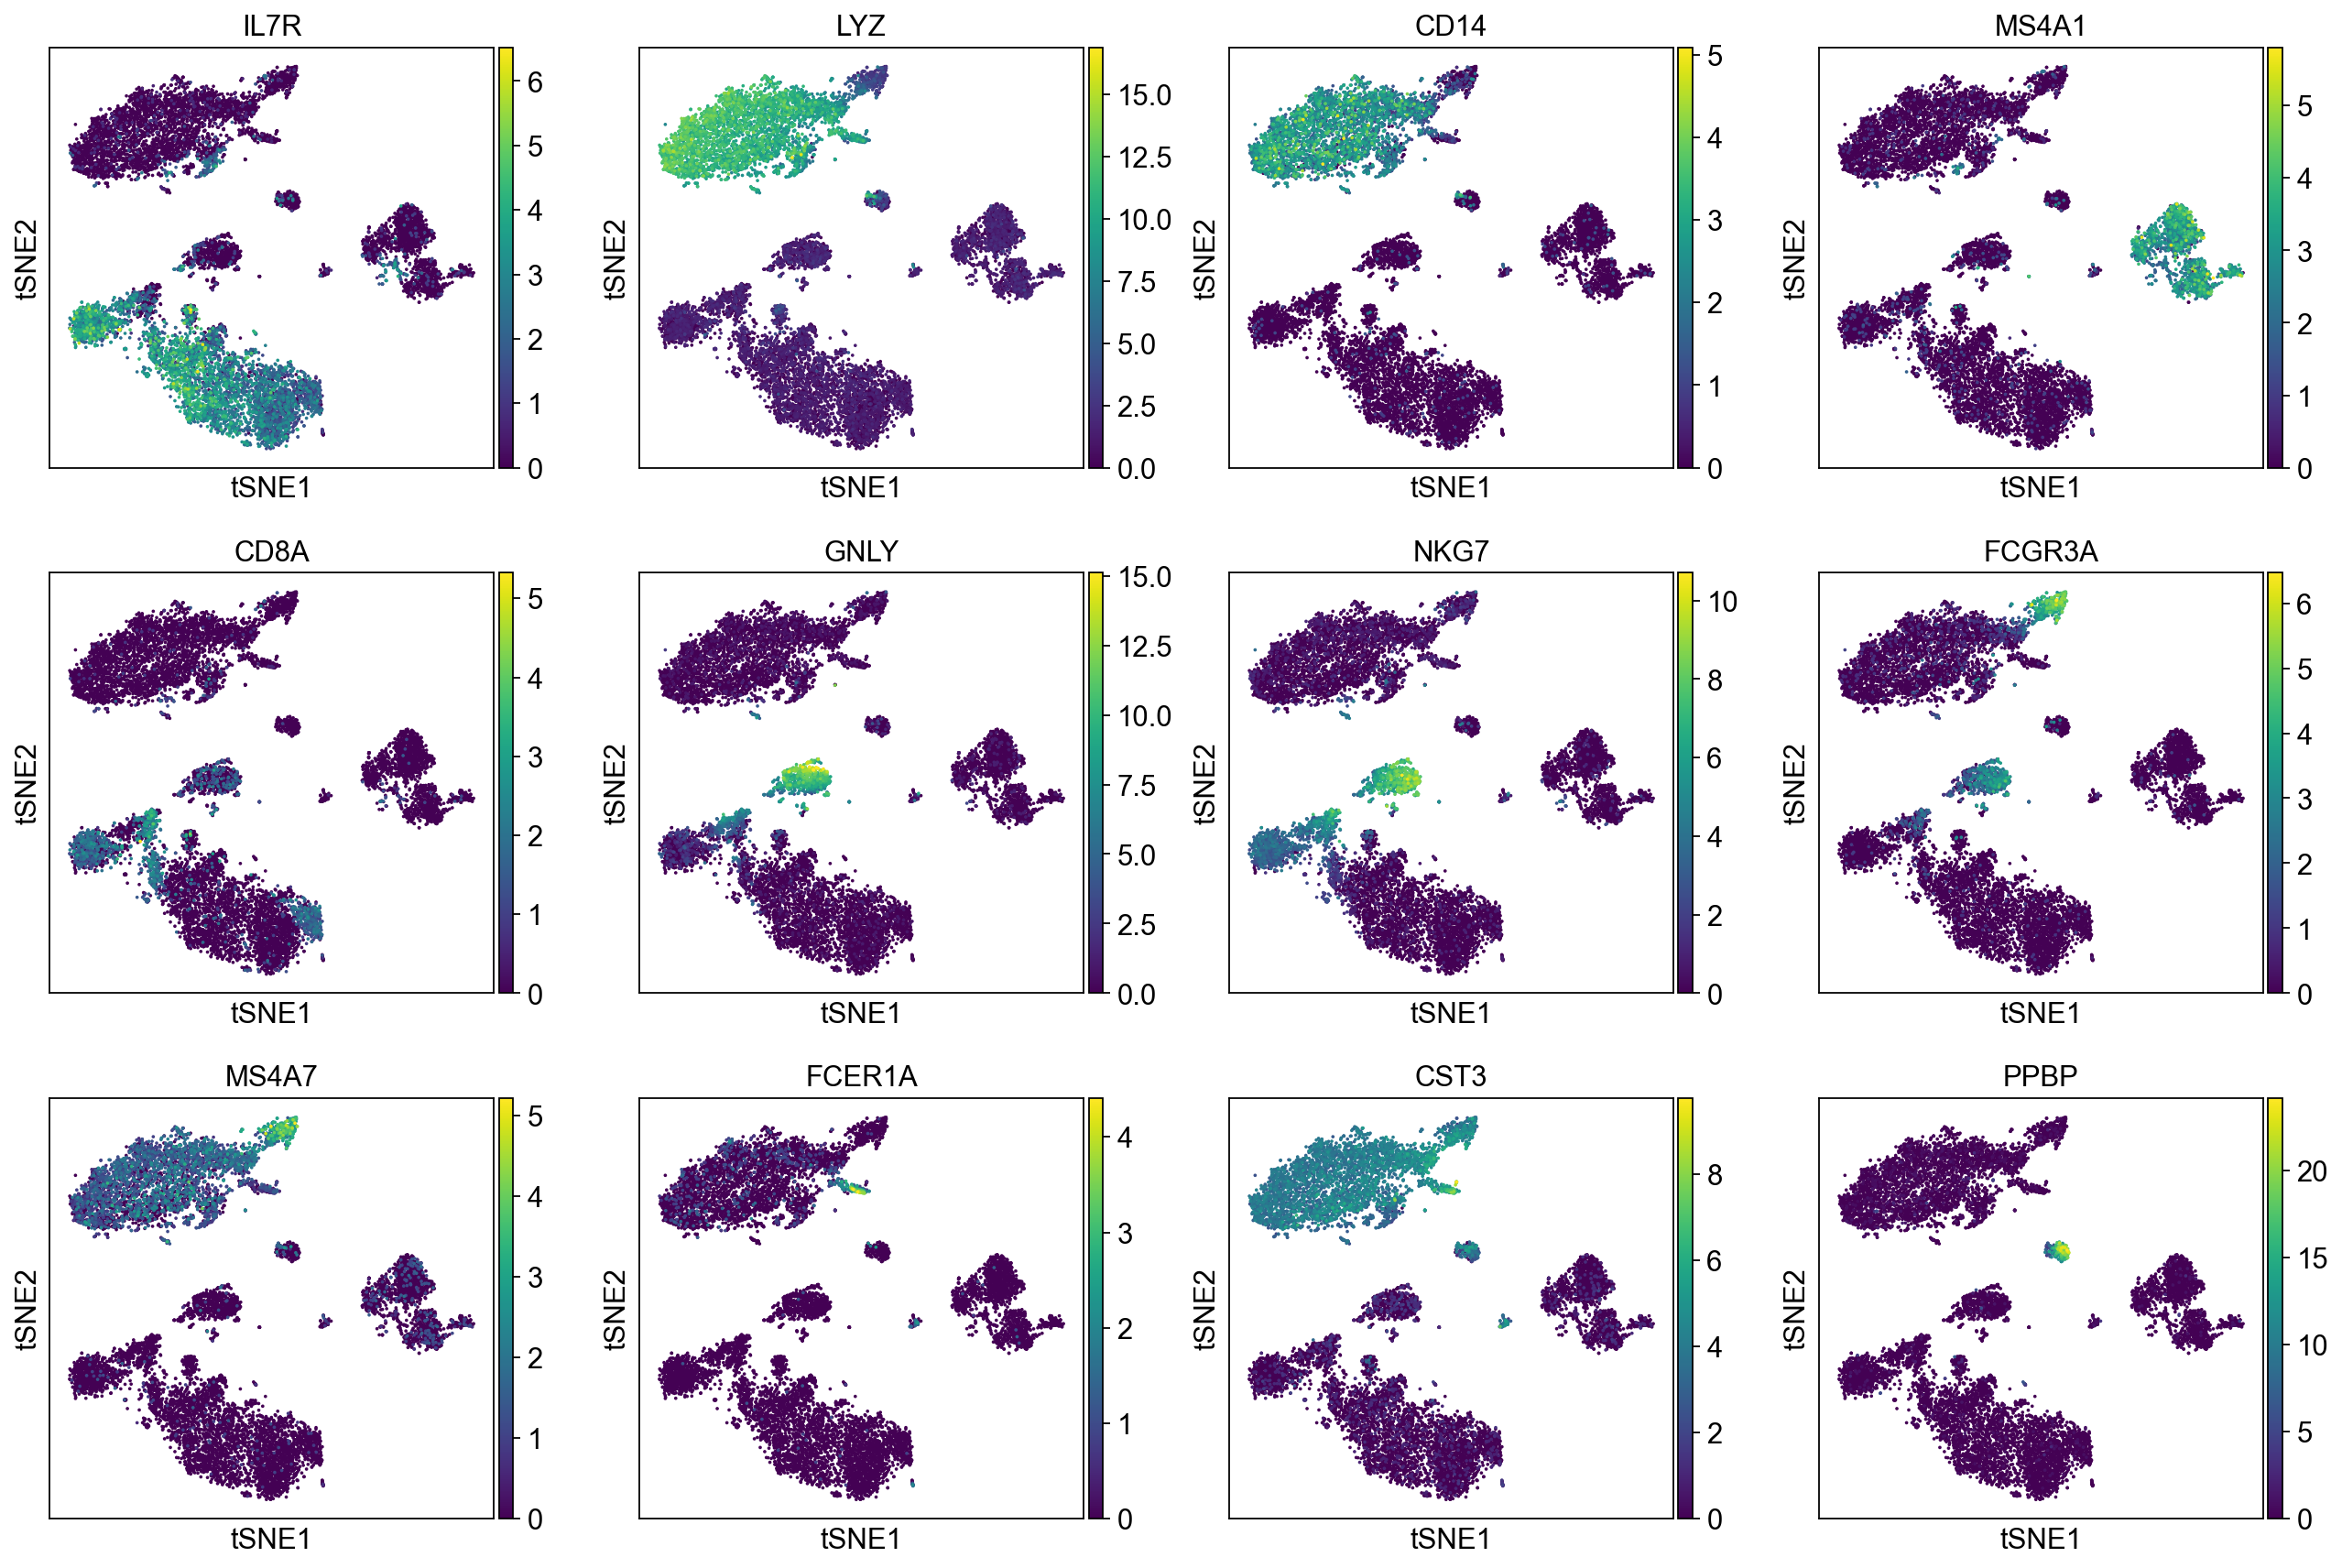

In [16]:
for adata in [adata_pbmc3k, adata_pbmc10k]:
    print(adata.uns["name"], ":")
    sc.pl.tsne(adata, color=["leiden"], cmap="tab20")
    sc.pl.tsne(adata, color=markers_scanpy, layer="sqrt_norm")

### Input arguments

The compuation of analytic Pearson residuals, as implemented here, has two key arguments besides the raw counts:

#### Overdispersion parameter `theta` 

To compute Pearson residuals, we need an estimation of the technical variance in the data. There is still a debate on which noise distribution is most appropiate for scRNA UMI data, with Poisson or the Negative binomial being likely candidates. We implemented the negative binomial model here, which is overdispersed compared to Poisson. The amount of overdispersion is controlled by the argument `theta`, where a smaller `theta` corresponds to larger overdispersion. [Lause et al. (2021)](https://www.biorxiv.org/content/10.1101/2020.12.01.405886v2) recommend using the default `theta=100`, as noise in negative control data without biological variation was fit well by this value. If Poisson behavior is desired, the overdispersion parameter can instead be set to infinity (`theta=np.Inf`).

#### Clipping threshold `clip`

When a gene is expressed in only very few cells, and missing in all others, it will generate very large residuals for these few cells. In turn, these cells might dominate in downstream processing. To avoid such unbalanced behavior, [Hafemeister & Satija (2019)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) introduced a heuristic that clips all residuals to `+-sqrt(n_cells)`. This is the default behavior of all functions for Pearson residuals discussed here. If desired, a different threshold can be set using the `clip` argument. If no clipping is desired, use `clip=np.Inf`.

### Best practice to obtain Pearson residuals for large datasets

Raw scRNA UMI counts are usually sparse, and can thus be stored efficiently for large datasets. However, when the count matrix is transformed to Pearson residuals, the data becomes dense. To avoid memory problems, we recommend that you reduce the size of your count matrix by gene selection, before running `normalize_pearson_residuals(adata)` on the reduced data. To perform RAM-efficient gene selection, use `highly_variable_genes(adata,flavor='pearson_residuals')` with the `chunksize` argument: This will still use Pearson residual variance to identify variable genes, but won't compute all residuals at once. Reduce the `chunksize` as needed if you run into RAM issues during gene selection.

### References / See also

[Hafemeister & Satija (2019)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1): Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression

[Lause et al. (2021)](https://www.biorxiv.org/content/10.1101/2020.12.01.405886v2): Analytic Pearson residuals for normalization of single-cell RNA-seq UMI data

[Wagner (2021)](https://www.youtube.com/watch?v=huxkc2GH4lk&t=2s): Overview/Introductory video: Normalization methods for single-cell RNA-Seq data